Music nDCG: 0.0087537
Tag nDCG: 0.260441
Score: 0.0465068



In [ ]:
!pip install implicit

     |████████████████████████████████| 1.1MB 8.8MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp36-cp36m-linux_x86_64.whl size=3419432 sha256=7d4c614557fcfe8674eca55fd312d925d033f1e271725f5285abc3c8f2222369
  Stored in directory: /root/.cache/pip/wheels/bf/d4/ec/fd4f622fcbefb7521f149905295b2c26adecb23af38aa28217
Successfully built implicit


In [ ]:
import pandas as pd
import numpy as np
from itertools import chain
from sklearn.utils import shuffle
import pickle
from scipy import sparse
from implicit.als import AlternatingLeastSquares as ALS

* 유사도 계산하는게 아니라 여기에 넣는게 맞는거같은뎅 ............?!

In [527]:
# train,val data
tr = pd.read_json("/content/drive/My Drive/Melon-PL-Continuation/0802/train_split/pickle/train.json", typ = 'frame')
val = pd.read_json("/content/drive/My Drive/Melon-PL-Continuation/0802/train_split/pickle/val_question.json", typ = 'frame')
val_answer = pd.read_json("/content/drive/My Drive/Melon-PL-Continuation/0802/train_split/pickle/val_answer.json", typ = 'frame')
# tr['id'] = tr.id.map(str) # surprise에서 inner id와 raw id 사이에 헷갈림 방지

# train playlist를 이용해서 곡 별 태그(new_tags)와 cluster id( PCA + K-means 결과)를 추가한 song_meta
song_meta = pd.read_pickle("/content/drive/My Drive/Melon-PL-Continuation/0802/train_split/song_meta_nov.pkl")
pca = pd.read_pickle("/content/drive/My Drive/Melon-PL-Continuation/0802/train_split/pca_kmean_nov_1000.pkl")
# pca = pd.read_pickle("/content/drive/My Drive/Melon-PL-Continuation/0802/train_split/pca_kmean_nov_1300.pkl")

# song_meta = pd.read_pickle("/content/drive/My Drive/Melon-PL-Continuation/0802/train_split/pickle/song_meta.pkl")
# pca = pd.read_pickle("/content/drive/My Drive/Melon-PL-Continuation/0802/train_split/pickle/0804_split_pca.pkl")
song_meta['raw_cid'] = pca['MiniBatchKmeans'].map(lambda x: f'c{x}')

print(len(set(song_meta['raw_cid'])))

999


In [528]:
len(set(tr.id)&set(val.id))

0

In [529]:
sid_to_title = dict(pd.Series(song_meta.song_name, index = song_meta.id))
sid_to_raw_cid = dict(zip(song_meta.id, song_meta.raw_cid))
n_clusters = len(set(song_meta['raw_cid']))
print(n_clusters)

999


In [530]:
tr_val = tr.copy()
tr_val = tr_val[tr_val.songs.map(len) > 100]

In [531]:
new_tags = list(set(chain.from_iterable(song_meta.new_tags)))

In [532]:
tr_val['new_tags'] = tr_val.tags.map(lambda x: [i for i in x if i in new_tags])
tr_val['raw_cid'] = tr_val.songs.map(lambda x:[sid_to_raw_cid[i] for i in x])
tr_val['raw_items'] = tr_val.raw_cid + tr_val.new_tags
tr_val

,tags,id,plylst_title,songs,like_cnt,updt_date,new_tags,raw_cid,raw_items
9,[발라드],41197,발라드 감성아재,"[487639, 279532, 131001, 72634, 611860, 625933...",0,2018-01-19 20:07:07.000,[발라드],"[c517, c156, c641, c373, c517, c517, c481, c59...","[c517, c156, c641, c373, c517, c517, c481, c59..."
16,"[슬픔, 이별, 설렘, 사랑]",97508,방대한 양의 듀엣곡 종결 리스트,"[245307, 114737, 135270, 337267, 226020, 45778...",38,2016-08-27 21:08:14.000,"[슬픔, 이별, 설렘, 사랑]","[c975, c289, c445, c239, c342, c536, c884, c34...","[c975, c289, c445, c239, c342, c536, c884, c34..."
22,"[아침, 운동, 드라이브, 여행, 기분전환, 스트레스, 신나는]",89216,❤DJ추천 1월 신곡 일렉트로니카 모음❤,"[214490, 327679, 346094, 456108, 683590, 40466...",6,2019-09-23 17:01:04.000,"[아침, 운동, 드라이브, 여행, 기분전환, 스트레스, 신나는]","[c271, c307, c307, c76, c307, c307, c307, c607...","[c271, c307, c307, c76, c307, c307, c307, c607..."
24,"[휴식, 힐링, 설렘, 사랑]",124000,20대후반친구들 들으면 좋은노래,"[319794, 107005, 153271, 267452, 680911, 57988...",22,2016-05-28 05:53:50.000,"[휴식, 힐링, 설렘, 사랑]","[c987, c231, c319, c517, c481, c163, c638, c16...","[c987, c231, c319, c517, c481, c163, c638, c16..."
31,"[감성, 밤, 발라드, 추억, 드라이브, 2000년대, 사랑, 이별]",102414,질리지않는 2000년대 명품발라드 모음.,"[82330, 515325, 405668, 80209, 166665, 104260,...",17715,2019-12-28 07:59:41.000,"[감성, 밤, 발라드, 추억, 드라이브, 2000년대, 사랑, 이별]","[c517, c517, c517, c345, c987, c517, c597, c51...","[c517, c517, c517, c345, c987, c517, c597, c51..."
...,...,...,...,...,...,...,...,...,...
92012,"[드라이브, 매장음악]",11969,일렉트로니카,"[53295, 425595, 460312, 416675, 273525, 512396...",36,2020-04-10 21:49:56.000,"[드라이브, 매장음악]","[c500, c788, c512, c875, c651, c562, c875, c56...","[c500, c788, c512, c875, c651, c562, c875, c56..."
92024,"[스트레스, 기분전환]",75622,신나는 아이돌노래,"[14820, 485589, 183579, 346379, 371341, 268210...",34,2016-09-01 14:18:50.000,"[스트레스, 기분전환]","[c726, c985, c144, c144, c684, c420, c144, c50...","[c726, c985, c144, c144, c684, c420, c144, c50..."
92032,"[사랑, 설렘, 잔잔한]",103591,★잔잔하고 달달한 랩&노래★,"[500576, 190777, 385234, 443495, 402611, 63162...",16,2014-09-02 22:15:33.000,"[사랑, 설렘, 잔잔한]","[c390, c769, c342, c342, c407, c163, c655, c40...","[c390, c769, c342, c342, c407, c163, c655, c40..."
92049,"[스트레스, 가을]",110161,가을과 어울리는 흔한듯 흔하지 않은 노래들,"[373762, 139472, 451946, 130955, 112652, 53866...",6,2014-09-16 09:56:16.000,"[스트레스, 가을]","[c51, c231, c156, c481, c715, c14, c240, c253,...","[c51, c231, c156, c481, c715, c14, c240, c253,..."


In [533]:
def flatten_series(nested_series, index):
    repeated_index = np.repeat(index, nested_series.map(len))
    return pd.DataFrame(chain.from_iterable(nested_series), index = repeated_index)

In [534]:
# 모든 rating은 1 
tg_ratings = flatten_series(tr_val.new_tags, tr_val.id).reset_index().rename(columns = {0:'iid'})
tg_ratings = tg_ratings.groupby(tg_ratings.columns.tolist()).size().reset_index().rename(columns = {0:'rating'})
tg_ratings

,id,iid,rating
0,41,감성,1
1,41,배경음악,1
2,107,2000년대,1
3,107,bgm,1
4,107,감성,1
...,...,...,...
26840,153405,댄스,1
26841,153418,아이돌,1
26842,153421,우울,1
26843,153421,이별,1


In [535]:
# 얘도 1/0으로 줘볼까?

cl_ratings = flatten_series(tr_val.raw_cid, tr_val.id).reset_index().rename(columns = {0:'iid'})
cl_ratings = cl_ratings.groupby(cl_ratings.columns.tolist()).size().reset_index().rename(columns = {0:'rating'})
cl_ratings

,id,iid,rating
0,25,c105,2
1,25,c150,3
2,25,c177,3
3,25,c222,11
4,25,c256,7
...,...,...,...
446445,153422,c96,1
446446,153422,c961,1
446447,153422,c978,5
446448,153422,c99,2


count    9004.000000
mean       49.583518
std        21.727121
min         1.000000
25%        34.000000
50%        48.000000
75%        63.000000
max       139.000000
Name: iid, dtype: float64

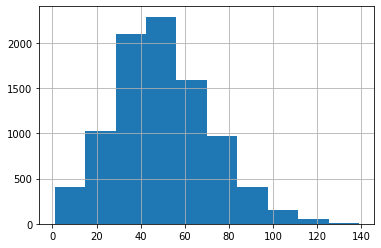

In [536]:
# 주로 몇개의 cluster를 이용하고 있을까?
# 평균 49개, 최대 139개의 cluster를 이용한다. => 모든 cluster의 정보를 이용하지 말고, 플레이리스트를 대표할 수 있는 cluster 몇개만을 추출하자.

cl_ratings.groupby('id').iid.size().hist()
cl_ratings.groupby('id').iid.size().describe()

In [540]:
# 15개만 쓴다면?
cl_ratings_tail = cl_ratings.groupby('id').apply(lambda x:x.sort_values('rating').tail(15))
cl_ratings_tail.reset_index(drop = True, inplace = True)
cl_ratings_tail

,id,iid,rating
0,25,c989,5
1,25,c330,7
2,25,c533,7
3,25,c256,7
4,25,c857,7
...,...,...,...
132456,153422,c374,8
132457,153422,c459,11
132458,153422,c156,16
132459,153422,c319,16


In [541]:
total = cl_ratings.groupby('id').rating.sum() # 포함된 전체 곡
in_tail = cl_ratings_tail.groupby('id').rating.sum() # tail에 포함된 곡
ratio = in_tail/total # tail/전체의 비율

count    9004.000000
mean        0.714198
std         0.162797
min         0.239796
25%         0.594103
50%         0.713395
75%         0.839653
max         1.000000
Name: rating, dtype: float64

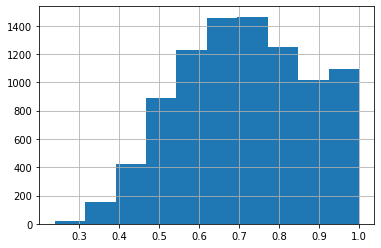

In [542]:
# 25% 이상이 전체 곡의 59%를 포함하고 있으며 절반 이상이 71% 이상을 포함하고 있다. 플레이 리스트의 정보를 충분히 표현할 수 있다고 판단한다.
ratio.hist()
ratio.describe()

In [543]:
cl_ratings_tail.loc[:,'rating'] = 1
cl_ratings_tail

,id,iid,rating
0,25,c989,1
1,25,c330,1
2,25,c533,1
3,25,c256,1
4,25,c857,1
...,...,...,...
132456,153422,c374,1
132457,153422,c459,1
132458,153422,c156,1
132459,153422,c319,1


In [544]:
selected_raw_cid = cl_ratings_tail.iid.unique().tolist()
selected_tags = tg_ratings.iid.unique().tolist()
selected_raw_items = selected_clusters + selected_tags

In [545]:
# to_index dictionary 만들기
raw_cid_to_index = {raw_cid:i for i,raw_cid in enumerate(selected_raw_cid)}
index_to_raw_cid = {j:i for i,j in raw_cid_to_index.items()}
n_clusters = len(raw_cid_to_index)

tag_to_index = {tag:i + n_clusters for i,tag in enumerate(selected_tags)}
index_to_tag = {j:i for i,j in tag_to_index.items()}
n_tags = len(tag_to_index)

ply_to_index = {ply:i for i,ply in enumerate(cl_ratings_tail.id.unique())}
index_to_ply = {j:i for i,j in ply_to_index.items()}

raw_items_to_index = {**raw_cid_to_index,**tag_to_index}

In [546]:
print('tag 수:',n_tags)
print('cluster 수:',n_clusters)

tag 수: 361
cluster 수: 931


In [547]:
cl_ratings_tail['iid'] = cl_ratings_tail['iid'].map(raw_cid_to_index)
tg_ratings['iid'] = tg_ratings['iid'].map(tag_to_index)

In [548]:
cl_tg = pd.concat([cl_ratings_tail, tg_ratings])
cl_tg['id'] = cl_tg['id'].map(ply_to_index)
cl_tg

,id,iid,rating
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1
...,...,...,...
26840,9000,962,1
26841,9001,963,1
26842,9002,1168,1
26843,9002,992,1


In [549]:
# cid_to_song(sorted by frequency)
song_freq = pd.DataFrame(pd.Series(chain.from_iterable(tr_val.songs)).value_counts(), columns = ["freq"])
song_freq['raw_cid'] = [sid_to_raw_cid[i] for i in song_freq.index.tolist()]
song_freq_dict = dict(song_freq.sort_values(['raw_cid','freq'], ascending=False).groupby('raw_cid').apply(lambda x:x.index.tolist()))

# log 관련

In [ ]:
# # log하면 괜찮아진다.

# import math
# log_ratings = cl_tg[~cl_tg.iid.str.isalpha()].rating.map(lambda x: math.log(x+2) if x > 3 else 0) # 해당 cluster에 적어도 4곡은 들어있어야 유효하다고 판단하자. (noise들 때문에 적합이 잘 안된듯)
# log_ratings.hist()
# display(log_ratings.describe())

In [ ]:
# # 2점과 10,12점 사이에 차이를 주면서 tag의 rating과 스케일을 맞춰준다.

# log_ratings.loc[cl_tg.id == index_to_uid[100]]

In [ ]:
# cl_tg.loc[~cl_tg.iid.str.isalpha(),'rating'] = log_ratings

In [ ]:
# cl_tg = cl_tg[cl_tg.rating>0]
# cl_tg

In [ ]:
# item_id = pd.Series(list(set(cl_tg.iid)))
# item_id

In [ ]:
# n_clusters = sum(item_id.str[0] == 'c')
# print(n_clusters)
# cid_to_index = {j:i for i,j in enumerate(item_id[item_id.str[0] == 'c'])}
# index_to_cid = {j:i for i,j in cid_to_index.items()}

In [ ]:
# tags = item_id[item_id.str[0] != 'c'].tolist()
# print(len(tags))

# tag_to_tid = {tags[i]:n_clusters + i for i in range(len(tags))}
# tid_to_tag = {tid:tag for tag,tid in tag_to_tid.items()}

In [ ]:
# cl_tg.loc[:,'iid2'] = cl_tg.iid.map(lambda x: cid_to_index[x] if x[0] == 'c' else tag_to_tid[x])
# cl_tg

# CSR matrix 만들기
##### USAGE
```
sparse.coo_matrix(([1,2,3],([1,1,3],[1,2,3]))).todense()
```

* coo_matrix로 만들건데, **indices**를 넣어야함 !!
* clusters + tags는 0~1112의 연속적인 값이니까 ok
* play list id는 단위가 크고 연속도 아니니까 `uid_to_index`를 이용해주자

In [ ]:
user_index = cl_tg.id
item_index = cl_tg.iid

user_item = sparse.coo_matrix((cl_tg.rating,(user_index, item_index)))

In [ ]:
user_item # ply list 총 92056개, clusters+tags 1112개 !

<9004x1292 sparse matrix of type '<class 'numpy.int64'>'
	with 159306 stored elements in COOrdinate format>

# ALS 방법으로 training [doc](https://implicit.readthedocs.io/en/latest/als.html)  
  
1. ALS model에 `user-item.T` 를 fitting한다.  
  input matrix는 csr 계열이 필요. `csr`, `coo_matrix` 등
2. song model과 tag model을 따로 선언하고
  1. user_factor를 1번 model의 `user-latent` matrix로 할당한다.
  2. item_factors는 1번 모델의 `item-latent` matrix를 slicing해서 할당한다.
3. `recommend` method를 이용해서 추천한다 !  
  알아서 user가 **소비하지 않은 item만** return한다.

##### 1. `user-song+tags` 로 fitting

In [ ]:
als_model = ALS(factors = 128, regularization = 0.02, iterations = 100) # use_gpu=True(default), iter 15(default)
als_model.fit(user_item.T*10)

In [ ]:
print("user - latent :",als_model.user_factors.shape)
print("item - latent :",als_model.item_factors.shape)

user - latent : (9004, 128)
item - latent : (1292, 128)


##### 2. songs/tags에 각각 ALS model을 선언하고 1에서 생성한 latent matrix를 잘라 각각 user, item에 할당

In [ ]:
# songs_model

song_model = ALS()
song_model.user_factors = als_model.user_factors # users-latent
song_model.item_factors = als_model.item_factors[:n_clusters] # songs-latent

# tags_model

tag_model = ALS()
tag_model.user_factors = als_model.user_factors # users-latent
tag_model.item_factors = als_model.item_factors[n_clusters:] # tags-latent

In [ ]:
print('songs - latent',als_model.item_factors[:n_clusters].shape)
print('tags - latent',als_model.item_factors[n_clusters:].shape)

songs - latent (931, 128)
tags - latent (361, 128)


In [ ]:
user_item_als = als_model.user_factors.dot(als_model.item_factors.T)
user_item_als

array([[ 8.6366951e-01,  9.6710265e-01,  9.8027593e-01, ...,
         8.9814365e-03,  3.4121231e-03,  1.0594348e-02],
       [ 2.1322677e-02, -5.1791526e-02,  1.9308092e-01, ...,
         1.3553531e-02,  1.5628787e-03,  3.5948288e-02],
       [ 8.2250588e-02,  1.6274105e-01, -1.6233167e-02, ...,
         5.6610783e-03,  7.0862686e-03,  3.4945685e-02],
       ...,
       [-3.5124715e-02,  4.5667950e-02,  6.9695073e-03, ...,
         8.4888572e-03, -3.8131068e-03, -2.1344490e-02],
       [ 8.9594334e-02,  5.2608538e-02,  3.3019937e-03, ...,
        -9.0287765e-03,  6.6081218e-02, -9.1614174e-03],
       [ 8.1193232e-04, -4.9367219e-02,  1.9596361e-02, ...,
        -1.1023720e-02,  3.0693468e-03, -1.9073470e-03]], dtype=float32)

In [ ]:
# 전부다 1 또는 0으로 예측하는 경우는 없어보인다!
user_item_als.round(3)

array([[ 0.864,  0.967,  0.98 , ...,  0.009,  0.003,  0.011],
       [ 0.021, -0.052,  0.193, ...,  0.014,  0.002,  0.036],
       [ 0.082,  0.163, -0.016, ...,  0.006,  0.007,  0.035],
       ...,
       [-0.035,  0.046,  0.007, ...,  0.008, -0.004, -0.021],
       [ 0.09 ,  0.053,  0.003, ..., -0.009,  0.066, -0.009],
       [ 0.001, -0.049,  0.02 , ..., -0.011,  0.003, -0.002]],
      dtype=float32)

In [ ]:
user_item_als.max(axis=1)

array([1.0415534, 1.0143535, 1.1668565, ..., 1.0243708, 1.0333903,
       1.0116272], dtype=float32)

In [ ]:
user_item_als.min(axis=1)

array([-0.29470044, -0.44809327, -0.5001632 , ..., -0.30799448,
       -0.30401567, -0.20368764], dtype=float32)

##### 3. recommendation에 이용할 orig matrix를 준비한다.
* als_model_object.recommend에는 user_index, orig_matrix가 필요하다.

In [ ]:
item_rec_csr = user_item.tocsr()[:, :n_clusters]
tag_rec_csr = user_item.tocsr()[:, n_clusters:]

# 잘 적합되었는지 체크

In [ ]:
# 출근길 등교길 산책 퇴근길 => 아침, 버스, 월요병, 지하철이 상위에 위치한다.
# tag는 적절하게 적합된 것으로 보인다. 그러나 ...

index = 8000
gt = tr_val[tr_val.id == index_to_ply[index]]
display(gt)

print([index_to_tag[index+n_clusters] for index in user_item_als[:,n_clusters:][index].argsort()[::-1][:10]])
print(sorted(user_item_als[:,n_clusters:][index])[::-1][:10])

print()
g = pd.DataFrame(pd.Series(gt.raw_cid.tolist()[0]).value_counts()[:15])
g.reset_index(inplace = True)
g['r_cid'] = g['index'].map(raw_cid_to_index)
display(g.iloc[:,[2,1]].T)

print(user_item_als[:,:n_clusters][index].argsort()[::-1][:15])
print(sorted(user_item_als[:,:n_clusters][index])[::-1][:15])

,tags,id,plylst_title,songs,like_cnt,updt_date,new_tags,raw_cid,raw_items
89109,"[여름, 여행, 댄스, 신나는]",136018,여름엔 케이팝이지,"[214965, 475558, 191431, 32131, 669566, 561788...",4,2019-07-05 21:25:08.000,"[여름, 여행, 댄스, 신나는]","[c144, c144, c144, c985, c144, c144, c420, c73...","[c144, c144, c144, c985, c144, c144, c420, c73..."


['신나는', '댄스', '여름', '여행', '아이돌', '산책', '걸그룹', '더위', '바다', '시원한']
[0.9493936, 0.9426311, 0.93353254, 0.9177291, 0.47308674, 0.46834347, 0.39450148, 0.37565377, 0.34866992, 0.3354705]



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
r_cid,39,77,74,28,129,76,33,16,131,162,127,26,298,24,46
0,79,36,13,11,8,7,6,5,4,4,3,3,2,2,2


[ 77  28  39  33  26  46 129  74  24 127 162 131  76  16 298]
[1.0452884, 1.015719, 1.0078647, 1.0006841, 0.9932601, 0.9914776, 0.9797638, 0.978432, 0.9744555, 0.9675177, 0.95510364, 0.9453953, 0.9434555, 0.9370758, 0.66674006]


In [ ]:
# 출근길 등교길 산책 퇴근길 => 아침, 버스, 월요병, 지하철이 상위에 위치한다.
# tag는 적절하게 적합된 것으로 보인다. 그러나 ...

index = 45
gt = tr_val[tr_val.id == index_to_ply[index]]
display(gt)

print([index_to_tag[index+n_clusters] for index in user_item_als[:,n_clusters:][index].argsort()[::-1][:10]])
print(sorted(user_item_als[:,n_clusters:][index])[::-1][:10])

print()
g = pd.DataFrame(pd.Series(gt.raw_cid.tolist()[0]).value_counts()[:15])
g.reset_index(inplace = True)
g['r_cid'] = g['index'].map(raw_cid_to_index)
display(g.iloc[:,[2,1]].T)

print(user_item_als[:,:n_clusters][index].argsort()[::-1][:15])
print(sorted(user_item_als[:,:n_clusters][index])[::-1][:15])

,tags,id,plylst_title,songs,like_cnt,updt_date,new_tags,raw_cid,raw_items
71503,"[비오는날, 서정, 카페, 새벽, 드라이브, 그리움, 감성, 기분, 사랑]",587,좋아서 담은 노래,"[147736, 264338, 40442, 448698, 376572, 173686...",57,2019-04-05 21:58:57.000,"[비오는날, 카페, 새벽, 드라이브, 그리움, 감성, 사랑]","[c641, c517, c641, c156, c118, c319, c517, c54...","[c641, c517, c641, c156, c118, c319, c517, c54..."


['감성', '사랑', '드라이브', '카페', '새벽', '비오는날', '밤', '이별', '그리움', '설렘']
[1.0052302, 0.94291425, 0.9347655, 0.88531536, 0.88104254, 0.87296367, 0.60989285, 0.5994467, 0.58336496, 0.4369258]



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
r_cid,43,24,26,40,46,139,23,53,17,42,136,52,50,51,45
0,8,7,6,6,6,6,5,5,5,5,4,4,4,3,3


[ 42  40  23  26  51  43  53  52  45  46  50  24  17 139 136]
[1.0074726, 1.0045351, 1.0011336, 0.9993751, 0.99909216, 0.9984181, 0.99674344, 0.990039, 0.98024505, 0.972391, 0.9623802, 0.957709, 0.9345135, 0.9000743, 0.8992674]


In [ ]:
index = 564
gt = tr_val[tr_val.id == index_to_ply[index]]
display(gt)

print([index_to_tag[index+n_clusters] for index in user_item_als[:,n_clusters:][index].argsort()[::-1][:10]])
print(sorted(user_item_als[:,n_clusters:][index])[::-1][:10])

print()
g = pd.DataFrame(pd.Series(gt.raw_cid.tolist()[0]).value_counts()[:15])
g.reset_index(inplace = True)
g['r_cid'] = g['index'].map(raw_cid_to_index)
display(g.iloc[:,[2,1]].T)

print(user_item_als[:,:n_clusters][index].argsort()[::-1][:15])
print(sorted(user_item_als[:,:n_clusters][index])[::-1][:15])

,tags,id,plylst_title,songs,like_cnt,updt_date,new_tags,raw_cid,raw_items
64537,"[새벽감성, 인디음악]",9271,"잠 못드는 새벽, 감성을 더해줄 인디음악","[542441, 310090, 169945, 454528, 264842, 18821...",11,2020-04-17 14:47:57.000,"[새벽감성, 인디음악]","[c319, c410, c319, c319, c156, c319, c156, c88...","[c319, c410, c319, c319, c156, c319, c156, c88..."


['인디', '인디음악', '새벽감성', '위로', '힘들때', '동요', '잔잔한', '어쿠스틱', '팝송', '새벽']
[0.79771614, 0.7188654, 0.5936721, 0.33869097, 0.2621884, 0.25881422, 0.25215757, 0.25028643, 0.24830224, 0.21933074]



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
r_cid,117,167,40,73,52,116,51,161,561,407,53,15,162,160,169
0,12,9,9,7,6,5,5,4,4,3,3,3,3,3,2


[161 167  53  51  15  40 116 162  52  73 117 160 169 407 171]
[1.0705572, 1.0383253, 1.0119046, 1.0040768, 1.0013684, 0.99195284, 0.98373955, 0.9826172, 0.9762692, 0.9718849, 0.96903497, 0.9439983, 0.7775122, 0.7504067, 0.72954917]


# train set에 대해 유사도 기법을 적용해도 잘 찾아낼까?

In [ ]:
n_values = n_clusters + n_tags

In [ ]:
norm = np.linalg.norm(user_item_als, axis = 1).reshape(-1,1)
scaled_user_item = user_item_als/norm
scaled_user_item.round(3)

array([[ 0.189,  0.212,  0.215, ...,  0.002,  0.001,  0.002],
       [ 0.004, -0.01 ,  0.036, ...,  0.003,  0.   ,  0.007],
       [ 0.015,  0.029, -0.003, ...,  0.001,  0.001,  0.006],
       ...,
       [-0.008,  0.01 ,  0.001, ...,  0.002, -0.001, -0.005],
       [ 0.019,  0.011,  0.001, ..., -0.002,  0.014, -0.002],
       [ 0.   , -0.01 ,  0.004, ..., -0.002,  0.001, -0.   ]],
      dtype=float32)

In [ ]:
tr_val.loc[:,'selected_raw_cid'] = tr_val.raw_cid.map(lambda x: [*filter(lambda x: x in selected_raw_cid,x)])
tr_val.loc[:,'selected_tags'] = tr_val.new_tags.map(lambda x: [*filter(lambda x: x in selected_tags,x)])
tr_val.loc[:,'c_index'] = tr_val.selected_raw_cid.map(lambda x:[raw_cid_to_index[i] for i in x])
tr_val.loc[:,'t_index'] = tr_val.selected_tags.map(lambda x:[tag_to_index[i] for i in x])
tr_val.loc[:,'ct_index'] = tr_val.c_index + tr_val.t_index
tr_val

,tags,id,plylst_title,songs,like_cnt,updt_date,new_tags,raw_cid,raw_items,selected_raw_cid,selected_tags,c_index,t_index,ct_index
9,[발라드],41197,발라드 감성아재,"[487639, 279532, 131001, 72634, 611860, 625933...",0,2018-01-19 20:07:07.000,[발라드],"[c517, c156, c641, c373, c517, c517, c481, c59...","[c517, c156, c641, c373, c517, c517, c481, c59...","[c517, c156, c641, c373, c517, c517, c481, c59...",[발라드],"[43, 53, 50, 214, 43, 43, 42, 26, 48, 518, 50,...",[998],"[43, 53, 50, 214, 43, 43, 42, 26, 48, 518, 50,..."
16,"[슬픔, 이별, 설렘, 사랑]",97508,방대한 양의 듀엣곡 종결 리스트,"[245307, 114737, 135270, 337267, 226020, 45778...",38,2016-08-27 21:08:14.000,"[슬픔, 이별, 설렘, 사랑]","[c975, c289, c445, c239, c342, c536, c884, c34...","[c975, c289, c445, c239, c342, c536, c884, c34...","[c975, c289, c445, c239, c342, c536, c884, c34...","[슬픔, 이별, 설렘, 사랑]","[49, 15, 69, 51, 24, 22, 117, 24, 52, 45, 164,...","[991, 992, 1010, 985]","[49, 15, 69, 51, 24, 22, 117, 24, 52, 45, 164,..."
22,"[아침, 운동, 드라이브, 여행, 기분전환, 스트레스, 신나는]",89216,❤DJ추천 1월 신곡 일렉트로니카 모음❤,"[214490, 327679, 346094, 456108, 683590, 40466...",6,2019-09-23 17:01:04.000,"[아침, 운동, 드라이브, 여행, 기분전환, 스트레스, 신나는]","[c271, c307, c307, c76, c307, c307, c307, c607...","[c271, c307, c307, c76, c307, c307, c307, c607...","[c271, c307, c307, c76, c307, c307, c307, c607...","[아침, 운동, 드라이브, 여행, 기분전환, 스트레스, 신나는]","[218, 125, 125, 610, 125, 125, 125, 178, 125, ...","[1133, 964, 935, 971, 947, 951, 944]","[218, 125, 125, 610, 125, 125, 125, 178, 125, ..."
24,"[휴식, 힐링, 설렘, 사랑]",124000,20대후반친구들 들으면 좋은노래,"[319794, 107005, 153271, 267452, 680911, 57988...",22,2016-05-28 05:53:50.000,"[휴식, 힐링, 설렘, 사랑]","[c987, c231, c319, c517, c481, c163, c638, c16...","[c987, c231, c319, c517, c481, c163, c638, c16...","[c987, c231, c319, c517, c481, c163, c638, c16...","[휴식, 힐링, 설렘, 사랑]","[48, 29, 40, 43, 42, 23, 34, 23, 303, 9, 270, ...","[948, 949, 1010, 985]","[48, 29, 40, 43, 42, 23, 34, 23, 303, 9, 270, ..."
31,"[감성, 밤, 발라드, 추억, 드라이브, 2000년대, 사랑, 이별]",102414,질리지않는 2000년대 명품발라드 모음.,"[82330, 515325, 405668, 80209, 166665, 104260,...",17715,2019-12-28 07:59:41.000,"[감성, 밤, 발라드, 추억, 드라이브, 2000년대, 사랑, 이별]","[c517, c517, c517, c345, c987, c517, c597, c51...","[c517, c517, c517, c345, c987, c517, c597, c51...","[c517, c517, c517, c345, c987, c517, c597, c51...","[감성, 밤, 발라드, 추억, 드라이브, 2000년대, 사랑, 이별]","[43, 43, 43, 115, 48, 43, 26, 43, 69, 43, 43, ...","[931, 936, 998, 937, 935, 933, 985, 992]","[43, 43, 43, 115, 48, 43, 26, 43, 69, 43, 43, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92012,"[드라이브, 매장음악]",11969,일렉트로니카,"[53295, 425595, 460312, 416675, 273525, 512396...",36,2020-04-10 21:49:56.000,"[드라이브, 매장음악]","[c500, c788, c512, c875, c651, c562, c875, c56...","[c500, c788, c512, c875, c651, c562, c875, c56...","[c500, c788, c512, c875, c651, c562, c875, c56...","[드라이브, 매장음악]","[282, 185, 641, 378, 253, 86, 378, 86, 94, 90,...","[935, 973]","[282, 185, 641, 378, 253, 86, 378, 86, 94, 90,..."
92024,"[스트레스, 기분전환]",75622,신나는 아이돌노래,"[14820, 485589, 183579, 346379, 371341, 268210...",34,2016-09-01 14:18:50.000,"[스트레스, 기분전환]","[c726, c985, c144, c144, c684, c420, c144, c50...","[c726, c985, c144, c144, c684, c420, c144, c50...","[c726, c985, c144, c144, c684, c420, c144, c50...","[스트레스, 기분전환]","[76, 77, 39, 39, 55, 74, 39, 33, 77, 16, 53, 7...","[951, 947]","[76, 77, 39, 39, 55, 74, 39, 33, 77, 16, 53, 7..."
92032,"[사랑, 설렘, 잔잔한]",103591,★잔잔하고 달달한 랩&노래★,"[500576, 190777, 385234, 443495, 402611, 63162...",16,2014-09-02 22:15:33.000,"[사랑, 설렘, 잔잔한]","[c390, c769, c342, c342, c407, c163, c655, c40...","[c390, c769, c342, c342, c407, c163, c655, c40...","[c390, c769, c342, c342, c407, c163, c655, c40...","[사랑, 설렘, 잔잔한]","[267, 778, 24, 24, 5, 23, 46, 5, 124, 5, 184, ...","[985, 1010, 968]","[267, 778, 24, 24, 5, 23, 46, 5, 124, 5, 184, ..."
92049,"[스트레스, 가을]",110161,가을과 어울리는 흔한듯 흔하지 않은 노래들,"[373762, 139472, 451946, 130955, 112652, 53866...",6,2014-09-16 09:56:16.000,"[스트레스, 가을]","[c51, c231, c156, c481, c715, c14, c240, c253,...","[c51, c2

# 유사한 플레이 리스트를 어떻게 찾아야 할까?
* 많이 나온 cluster에 가중치를 주자
* 있다/없다로만 하자 (채택!)
> 가중치를 주게 되면 특정 cluster 하나만 겹치더라도 전체 점수가 올라갈 수 있음  
> ex : [8,0,0,0,1,1,1]과 [1,0,0,...]  
  그러나 [1,0,0,...,0]인 cluster보다는 [1,0,0,0,1,1,1]인 cluster와 더 유사할 가능성이 높음! (가려진 정보도 있으므로)  
> 물론 점수가 높은 cluster에 집중하는 것이 좋은 경우도 있지만? 

In [ ]:
# 1,0으로 줬으니까 이건 안하는게 맞네!

# index = 8000
# target = tr_val[tr_val.id == index_to_ply[index]]
# display(target)
# values = list(set(target.ct_index.tolist()[0]))
# s = np.eye(n_values)[values].sum(axis = 0)

# print("candidates 1 ---")
# sim = user_item_als.dot(s)
# top5 = sim.argsort()[::-1][:5]
# most_similar_ply = sim.argmax()
# print("1등은! :",most_similar_ply)
# print("비슷한 플레이 리스트 상위 5개",top5)
# print("점수\t\t\t",sorted(sim.round(3))[::-1][:5])
# display(tr_val[tr_val.id.isin([index_to_ply[i] for i in top5])])

# print()
# print("candidates 2 ---")
# sim = scaled_user_item.dot(s)
# top5 = sim.argsort()[::-1][:5]
# most_similar_ply = sim.argmax()
# print("1등은! :",most_similar_ply)
# print("비슷한 플레이 리스트 상위 5개",top5)
# print("점수\t\t\t",sorted(sim.round(3))[::-1][:5])
# display(tr_val[tr_val.id.isin([index_to_ply[i] for i in top5])])

In [ ]:
index = 7234
target = tr_val[tr_val.id == index_to_ply[index]]
display(target)

print("candidates 1 ---")
values = list(set(target.ct_index.tolist()[0]))
s = np.eye(n_values)[values].sum(axis = 0)
sim = user_item_als.dot(s)
top5 = sim.argsort()[::-1][:5]
most_similar_ply = sim.argmax()
print("1등은! :",most_similar_ply)
print("비슷한 플레이 리스트 상위 5개",top5)
print("점수\t\t\t",sorted(sim.round(3))[::-1][:5])
display(tr_val[tr_val.id.isin([index_to_ply[i] for i in top5])])

print()
values = target.ct_index.tolist()[0]
s = np.eye(n_values)[values].sum(axis = 0)
sim = user_item_als.dot(s)
top5 = sim.argsort()[::-1][:5]
most_similar_ply = sim.argmax()
print("1등은! :",most_similar_ply)
print("비슷한 플레이 리스트 상위 5개",top5)
print("점수\t\t\t",sorted(sim.round(3))[::-1][:5])
display(tr_val[tr_val.id.isin([index_to_ply[i] for i in top5])])

,tags,id,plylst_title,songs,like_cnt,updt_date,new_tags,raw_cid,raw_items,selected_raw_cid,selected_tags,c_index,t_index,ct_index
33218,"[클럽, 아침, 취향저격, 월요병, 추억, 드라이브, 여행, 파티, 그루브, 스트레스]",122090,세련된 편집샵 느낌에 곡:),"[346967, 377349, 352965, 460779, 310116, 57066...",239,2020-04-23 15:02:05.000,"[클럽, 아침, 취향저격, 월요병, 추억, 드라이브, 여행, 파티, 그루브, 스트레스]","[c239, c562, c533, c651, c564, c374, c533, c65...","[c239, c562, c533, c651, c564, c374, c533, c65...","[c239, c562, c533, c651, c564, c374, c533, c65...","[클럽, 아침, 취향저격, 월요병, 추억, 드라이브, 여행, 파티, 그루브, 스트레스]","[51, 86, 2, 253, 79, 85, 2, 46, 461, 79, 83, 8...","[945, 1133, 975, 1189, 937, 935, 971, 1215, 10...","[51, 86, 2, 253, 79, 85, 2, 46, 461, 79, 83, 8..."


candidates 1 ---
1등은! : 7234
비슷한 플레이 리스트 상위 5개 [7234 8729 1923 6316 5235]
점수			 [29.599, 27.246, 26.206, 23.819, 23.459]


,tags,id,plylst_title,songs,like_cnt,updt_date,new_tags,raw_cid,raw_items,selected_raw_cid,selected_tags,c_index,t_index,ct_index
22,"[아침, 운동, 드라이브, 여행, 기분전환, 스트레스, 신나는]",89216,❤DJ추천 1월 신곡 일렉트로니카 모음❤,"[214490, 327679, 346094, 456108, 683590, 40466...",6,2019-09-23 17:01:04.000,"[아침, 운동, 드라이브, 여행, 기분전환, 스트레스, 신나는]","[c271, c307, c307, c76, c307, c307, c307, c607...","[c271, c307, c307, c76, c307, c307, c307, c607...","[c271, c307, c307, c76, c307, c307, c307, c607...","[아침, 운동, 드라이브, 여행, 기분전환, 스트레스, 신나는]","[218, 125, 125, 610, 125, 125, 125, 178, 125, ...","[1133, 964, 935, 971, 947, 951, 944]","[218, 125, 125, 610, 125, 125, 125, 178, 125, ..."
4424,"[집중, 가을감성, 출근길, 아침, 취향저격, 월요병, 추억, 그루브, 스트레스]",148900,트렌디하고 감각적인 매장음악!,"[362560, 449836, 318350, 210869, 362695, 69404...",28,2020-03-30 04:17:13.000,"[집중, 가을감성, 출근길, 아침, 취향저격, 월요병, 추억, 그루브, 스트레스]","[c472, c103, c750, c651, c374, c946, c651, c56...","[c472, c103, c750, c651, c374, c946, c651, c56...","[c472, c103, c750, c651, c374, c946, c651, c56...","[집중, 가을감성, 출근길, 아침, 취향저격, 월요병, 추억, 그루브, 스트레스]","[88, 61, 336, 253, 85, 95, 253, 86, 253, 86, 8...","[1040, 1051, 980, 1133, 975, 1189, 937, 1021, ...","[88, 61, 336, 253, 85, 95, 253, 86, 253, 86, 8..."
13153,"[출근길, 아침, 취향저격, 월요병, 추억, 드라이브, 그루브, 파티, 스트레스]",31809,한번쯤 들어봤을 swag 가득한 music!!(상시 업데이트!),"[515592, 352965, 405539, 460779, 146989, 40496...",113,2020-04-23 15:02:43.000,"[출근길, 아침, 취향저격, 월요병, 추억, 드라이브, 그루브, 파티, 스트레스]","[c562, c533, c37, c651, c655, c403, c655, c85,...","[c562, c533, c37, c651, c655, c403, c655, c85,...","[c562, c533, c37, c651, c655, c403, c655, c85,...","[출근길, 아침, 취향저격, 월요병, 추억, 드라이브, 그루브, 파티, 스트레스]","[86, 2, 462, 253, 46, 369, 46, 482, 400, 182, ...","[980, 1133, 975, 1189, 937, 935, 1021, 1215, 951]","[86, 2, 462, 253, 46, 369, 46, 482, 400, 182, ..."
33218,"[클럽, 아침, 취향저격, 월요병, 추억, 드라이브, 여행, 파티, 그루브, 스트레스]",122090,세련된 편집샵 느낌에 곡:),"[346967, 377349, 352965, 460779, 310116, 57066...",239,2020-04-23 15:02:05.000,"[클럽, 아침, 취향저격, 월요병, 추억, 드라이브, 여행, 파티, 그루브, 스트레스]","[c239, c562, c533, c651, c564, c374, c533, c65...","[c239, c562, c533, c651, c564, c374, c533, c65...","[c239, c562, c533, c651, c564, c374, c533, c65...","[클럽, 아침, 취향저격, 월요병, 추억, 드라이브, 여행, 파티, 그루브, 스트레스]","[51, 86, 2, 253, 79, 85, 2, 46, 461, 79, 83, 8...","[945, 1133, 975, 1189, 937, 935, 971, 1215, 10...","[51, 86, 2, 253, 79, 85, 2, 46, 461, 79, 83, 8..."
74191,"[자기전, 회사에서몰래, 드라이브, 여행, 기분전환, 퇴근길, 스트레스, 신나는]",106729,홍재의귓구녕 (8/23 updated),"[160731, 484278, 26865, 427128, 197987, 69763,...",112,2019-08-23 17:24:57.000,"[드라이브, 여행, 기분전환, 퇴근길, 스트레스, 신나는]","[c651, c875, c93, c374, c875, c607, c875, c887...","[c651, c875, c93, c374, c875, c607, c875, c887...","[c651, c875, c93, c374, c875, c607, c875, c887...","[드라이브, 여행, 기분전환, 퇴근길, 스트레스, 신나는]","[253, 378, 155, 85, 378, 178, 378, 328, 90, 97...","[935, 971, 947, 965, 951, 944]","[253, 378, 155, 85, 378, 178, 378, 328, 90, 97..."



1등은! : 7234
비슷한 플레이 리스트 상위 5개 [7234 1923 8729  925 6316]
점수			 [88.412, 81.824, 79.252, 77.164, 75.827]


,tags,id,plylst_title,songs,like_cnt,updt_date,new_tags,raw_cid,raw_items,selected_raw_cid,selected_tags,c_index,t_index,ct_index
4424,"[집중, 가을감성, 출근길, 아침, 취향저격, 월요병, 추억, 그루브, 스트레스]",148900,트렌디하고 감각적인 매장음악!,"[362560, 449836, 318350, 210869, 362695, 69404...",28,2020-03-30 04:17:13.000,"[집중, 가을감성, 출근길, 아침, 취향저격, 월요병, 추억, 그루브, 스트레스]","[c472, c103, c750, c651, c374, c946, c651, c56...","[c472, c103, c750, c651, c374, c946, c651, c56...","[c472, c103, c750, c651, c374, c946, c651, c56...","[집중, 가을감성, 출근길, 아침, 취향저격, 월요병, 추억, 그루브, 스트레스]","[88, 61, 336, 253, 85, 95, 253, 86, 253, 86, 8...","[1040, 1051, 980, 1133, 975, 1189, 937, 1021, ...","[88, 61, 336, 253, 85, 95, 253, 86, 253, 86, 8..."
13153,"[출근길, 아침, 취향저격, 월요병, 추억, 드라이브, 그루브, 파티, 스트레스]",31809,한번쯤 들어봤을 swag 가득한 music!!(상시 업데이트!),"[515592, 352965, 405539, 460779, 146989, 40496...",113,2020-04-23 15:02:43.000,"[출근길, 아침, 취향저격, 월요병, 추억, 드라이브, 그루브, 파티, 스트레스]","[c562, c533, c37, c651, c655, c403, c655, c85,...","[c562, c533, c37, c651, c655, c403, c655, c85,...","[c562, c533, c37, c651, c655, c403, c655, c85,...","[출근길, 아침, 취향저격, 월요병, 추억, 드라이브, 그루브, 파티, 스트레스]","[86, 2, 462, 253, 46, 369, 46, 482, 400, 182, ...","[980, 1133, 975, 1189, 937, 935, 1021, 1215, 951]","[86, 2, 462, 253, 46, 369, 46, 482, 400, 182, ..."
33218,"[클럽, 아침, 취향저격, 월요병, 추억, 드라이브, 여행, 파티, 그루브, 스트레스]",122090,세련된 편집샵 느낌에 곡:),"[346967, 377349, 352965, 460779, 310116, 57066...",239,2020-04-23 15:02:05.000,"[클럽, 아침, 취향저격, 월요병, 추억, 드라이브, 여행, 파티, 그루브, 스트레스]","[c239, c562, c533, c651, c564, c374, c533, c65...","[c239, c562, c533, c651, c564, c374, c533, c65...","[c239, c562, c533, c651, c564, c374, c533, c65...","[클럽, 아침, 취향저격, 월요병, 추억, 드라이브, 여행, 파티, 그루브, 스트레스]","[51, 86, 2, 253, 79, 85, 2, 46, 461, 79, 83, 8...","[945, 1133, 975, 1189, 937, 935, 971, 1215, 10...","[51, 86, 2, 253, 79, 85, 2, 46, 461, 79, 83, 8..."
69023,"[홈파티, 그루브, 외힙, 파티, 외국힙합, 팝, 신나는]",15476,만능 파티 플레이리스트,"[659771, 233765, 40937, 615507, 236393, 524340...",1,2020-04-21 04:59:16.000,"[그루브, 외힙, 파티, 외국힙합, 팝, 신나는]","[c174, c356, c374, c562, c655, c647, c655, c37...","[c174, c356, c374, c562, c655, c647, c655, c37...","[c174, c356, c374, c562, c655, c647, c655, c37...","[그루브, 외힙, 파티, 외국힙합, 팝, 신나는]","[83, 97, 85, 86, 46, 59, 46, 85, 85, 369, 85, ...","[1021, 1150, 1215, 1081, 950, 944]","[83, 97, 85, 86, 46, 59, 46, 85, 85, 369, 85, ..."
74191,"[자기전, 회사에서몰래, 드라이브, 여행, 기분전환, 퇴근길, 스트레스, 신나는]",106729,홍재의귓구녕 (8/23 updated),"[160731, 484278, 26865, 427128, 197987, 69763,...",112,2019-08-23 17:24:57.000,"[드라이브, 여행, 기분전환, 퇴근길, 스트레스, 신나는]","[c651, c875, c93, c374, c875, c607, c875, c887...","[c651, c875, c93, c374, c875, c607, c875, c887...","[c651, c875, c93, c374, c875, c607, c875, c887...","[드라이브, 여행, 기분전환, 퇴근길, 스트레스, 신나는]","[253, 378, 155, 85, 378, 178, 378, 328, 90, 97...","[935, 971, 947, 965, 951, 944]","[253, 378, 155, 85, 378, 178, 378, 328, 90, 97..."


# val에 대해

In [ ]:
val_answer['new_tags'] = val_answer.tags.map(lambda x: [i for i in x if i in new_tags])
val_answer['raw_cid'] = val_answer.songs.map(lambda x:[sid_to_raw_cid[i] for i in x])
val_answer['raw_items'] = val_answer.raw_cid + val.new_tags
val_answer.loc[:,'selected_raw_cid'] = val_answer.raw_cid.map(lambda x: [*filter(lambda x: x in selected_raw_cid,x)])
val_answer.loc[:,'selected_tags'] = val_answer.new_tags.map(lambda x: [*filter(lambda x: x in selected_tags,x)])
val_answer.loc[:,'c_index'] = val_answer.selected_raw_cid.map(lambda x:[raw_cid_to_index[i] for i in x])
val_answer.loc[:,'t_index'] = val_answer.selected_tags.map(lambda x:[tag_to_index[i] for i in x])
val_answer.loc[:,'ct_index'] = val_answer.c_index + val_answer.t_index
val_answer

,tags,id,plylst_title,songs,like_cnt,updt_date,new_tags,raw_cid,raw_items,selected_raw_cid,selected_tags,c_index,t_index,ct_index
0,"[playmusic, random, Pop]",147332,랜덤 플레이 뮤직 - 팝,"[651057, 475555, 86031, 663555, 463760, 268674...",4,2020-03-31 00:45:30.000,[Pop],"[c998, c655, c998, c669, c875, c998, c633, c62...","[c998, c655, c998, c669, c875, c998, c633, c62...","[c998, c655, c998, c669, c875, c998, c633, c62...",[Pop],"[72, 46, 72, 181, 378, 72, 98, 177, 182, 177, ...",[1003],"[72, 46, 72, 181, 378, 72, 98, 177, 182, 177, ..."
1,"[힐링, 휴식]",63876,ㅇㅇㅇㅇㄹ,"[222763, 456665, 429530, 689455, 545344, 45858...",10,2017-02-01 22:42:47.000,"[힐링, 휴식]","[c319, c319, c156, c517, c975, c14, c414, c511...","[c319, c319, c156, c517, c975, c14, c414, c511...","[c319, c319, c156, c517, c975, c14, c414, c511...","[힐링, 휴식]","[40, 40, 53, 43, 49, 36, 174, 216, 23, 23, 258...","[949, 948]","[40, 40, 53, 43, 49, 36, 174, 216, 23, 23, 258..."
2,[트로트],2205,트로트1,"[35848, 638330, 132604, 666824, 231868, 546740...",43,2019-10-16 18:56:01.000,[트로트],"[c400, c400, c400, c296, c400, c467, c144, c40...","[c400, c400, c400, c296, c400, c467, c144, c40...","[c400, c400, c400, c296, c400, c467, c144, c40...",[트로트],"[113, 113, 113, 109, 113, 114, 39, 113, 113, 113]",[952],"[113, 113, 113, 109, 113, 114, 39, 113, 113, 1..."
3,"[힐링, 휴식]",43060,삶이 지치고 힘들때 위로되는 힐링팝송,"[158944, 62200, 490266, 352459, 79312, 424421,...",952,2016-05-06 01:28:43.000,"[힐링, 휴식]","[c712, c998, c445, c520, c998, c720, c998, c92...","[c712, c998, c445, c520, c998, c720, c998, c92...","[c712, c998, c445, c520, c998, c720, c998, c92...","[힐링, 휴식]","[25, 72, 69, 62, 72, 836, 72, 67, 61, 217, 35,...","[949, 948]","[25, 72, 69, 62, 72, 836, 72, 67, 61, 217, 35,..."
4,"[추억, 사랑, 설렘, 회상]",89571,어버이날 안성맞춤 세대초월 노래들,"[562769, 305761, 123335, 300382, 156051, 17820...",8,2016-05-08 09:38:44.000,"[추억, 사랑, 설렘, 회상]","[c790, c584, c270, c126, c308, c642, c424, c48...","[c790, c584, c270, c126, c308, c642, c424, c48...","[c790, c584, c270, c126, c308, c642, c424, c48...","[추억, 사랑, 설렘, 회상]","[715, 135, 260, 257, 289, 639, 100, 42, 111, 8...","[937, 985, 1010, 938]","[715, 135, 260, 257, 289, 639, 100, 42, 111, 8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23010,"[힙합, 국내힙합, 기분전환, 쇼미더머니, 국힙, 신나는]",152338,국내 힙합 좋은 노래 모음 ❤,"[143652, 638064, 592386, 402547, 451198, 19053...",6,2019-11-04 00:25:11.000,"[힙합, 국내힙합, 기분전환, 국힙, 신나는]","[c371, c655, c371, c647, c371, c634, c371, c64...","[c371, c655, c371, c647, c371, c634, c371, c64...","[c371, c655, c371, c647, c371, c634, c371, c64...","[힙합, 국내힙합, 기분전환, 국힙, 신나는]","[9, 46, 9, 59, 9, 60, 9, 59, 13, 58, 59, 59, 4...","[946, 941, 947, 942, 944]","[9, 46, 9, 59, 9, 60, 9, 59, 13, 58, 59, 59, 4..."
23011,[락],116761,장르불문! 국적불문! 강추 아티스트!,"[703129, 336157, 87662, 474318, 229264, 611351...",3,2012-12-06 18:18:52.000,[락],"[c680, c705, c136, c847, c122, c117, c998, c79...","[c680, c705, c136, c847, c122, c117, c998, c79...","[c680, c705, c136, c847, c122, c117, c998, c79...",[락],"[217, 873, 632, 35, 624, 68, 72, 345, 631, 487...",[1025],"[217, 873, 632, 35, 624, 68, 72, 345, 631, 487..."
23012,[댄스],121399,기분 업하고싶니?,"[340052, 458812, 481045, 486768, 268289, 15944...",19,2009-09-12 21:55:50.000,[댄스],"[c956, c113, c622, c144, c645, c622, c144, c64...","[c956, c113, c622, c144, c645, c622, c144, c64...","[c956, c113, c622, c144, c645, c622, c144, c64...",[댄스],"[131, 127, 31, 39, 227, 31, 39, 227, 127, 39, ...",[962],"[131, 127, 31, 39, 227, 31, 39, 227, 127, 39, ..."
23013,"[여름, 기분전환]",79747,기분 좋아지는 시원한 곡들,"[443785, 78983, 179646, 108216, 498274, 274165...",63,2015-02-23 11:40:16.000,"[여름, 기분전환]","[c259, c847, c520, c562, c271, c698, c562, c84...","[c259, c847, c520, c562, c271, c698, c562, c84...","[c259, c847, c520, c562, c271, c698, c562, c84...","[여름, 기분전환]","[535, 35, 62, 86, 218, 64, 86, 35, 86, 85, 85,...","[995, 947]","[535, 35, 62, 86, 218, 64, 86, 35, 86, 85, 85,..."


In [ ]:
val['new_tags'] = val.tags.map(lambda x: [i for i in x if i in new_tags])
val['raw_cid'] = val.songs.map(lambda x:[sid_to_raw_cid[i] for i in x])
val['raw_items'] = val.raw_cid + val.new_tags
val.loc[:,'selected_raw_cid'] = val.raw_cid.map(lambda x: [*filter(lambda x: x in selected_raw_cid,x)])
val.loc[:,'selected_tags'] = val.new_tags.map(lambda x: [*filter(lambda x: x in selected_tags,x)])
val.loc[:,'c_index'] = val.selected_raw_cid.map(lambda x:[raw_cid_to_index[i] for i in x])
val.loc[:,'t_index'] = val.selected_tags.map(lambda x:[tag_to_index[i] for i in x])
val.loc[:,'ct_index'] = val.c_index + val.t_index
val

,tags,id,plylst_title,songs,like_cnt,updt_date,new_tags,raw_cid,raw_items,selected_raw_cid,selected_tags,c_index,t_index,ct_index
0,"[Billboard, uspop]",147332,랜덤 플레이 뮤직 - 팝,[],4,2020-03-31 00:45:30.000,[],[],[],[],[],[],[],[]
1,[겨울],63876,ㅇㅇㅇㅇㄹ,"[279590, 680756, 651499, 10624, 438424, 533739...",10,2017-02-01 22:42:47.000,[겨울],"[c597, c481, c319, c987, c517, c156, c641, c48...","[c597, c481, c319, c987, c517, c156, c641, c48...","[c597, c481, c319, c987, c517, c156, c641, c48...",[겨울],"[26, 42, 40, 48, 43, 53, 50, 42, 48, 43, 40, 5...",[1042],"[26, 42, 40, 48, 43, 53, 50, 42, 48, 43, 40, 5..."
2,[],2205,트로트1,[],43,2019-10-16 18:56:01.000,[],[],[],[],[],[],[],[]
3,[기분전환],43060,삶이 지치고 힘들때 위로되는 힐링팝송,"[331055, 144856, 236393, 679436, 625875, 11657...",952,2016-05-06 01:28:43.000,[기분전환],"[c459, c319, c655, c655, c459, c459, c15, c660...","[c459, c319, c655, c655, c459, c459, c15, c660...","[c459, c319, c655, c655, c459, c459, c15, c660...",[기분전환],"[52, 40, 46, 46, 52, 52, 389, 87, 217, 35, 80,...",[947],"[52, 40, 46, 46, 52, 52, 389, 87, 217, 35, 80,..."
4,[],89571,어버이날 안성맞춤 세대초월 노래들,"[367826, 630180, 382117, 442580, 570532, 14707...",8,2016-05-08 09:38:44.000,[],"[c305, c700, c356, c531, c640, c390, c511, c12...","[c305, c700, c356, c531, c640, c390, c511, c12...","[c305, c700, c356, c531, c640, c390, c511, c12...",[],"[531, 471, 97, 614, 351, 267, 216, 257, 223, 1...",[],"[531, 471, 97, 614, 351, 267, 216, 257, 223, 1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23010,[],152338,국내 힙합 좋은 노래 모음 ❤,"[454218, 156278, 679405, 356571, 413422, 59240...",6,2019-11-04 00:25:11.000,[],"[c655, c533, c371, c371, c655, c647, c670, c65...","[c655, c533, c371, c371, c655, c647, c670, c65...","[c655, c533, c371, c371, c655, c647, c670, c65...",[],"[46, 2, 9, 9, 46, 59, 7, 46, 59, 59, 59, 59, 9...",[],"[46, 2, 9, 9, 46, 59, 7, 46, 59, 59, 59, 59, 9..."
23011,[],116761,장르불문! 국적불문! 강추 아티스트!,"[62440, 648536, 552968, 449287, 437232, 317490...",3,2012-12-06 18:18:52.000,[],"[c376, c51, c21, c788, c520, c419, c95, c576, ...","[c376, c51, c21, c788, c520, c419, c95, c576, ...","[c376, c51, c21, c788, c520, c419, c95, c576, ...",[],"[186, 634, 846, 185, 62, 553, 631, 522, 380, 3...",[],"[186, 634, 846, 185, 62, 553, 631, 522, 380, 3..."
23012,[],121399,기분 업하고싶니?,"[144826, 663719, 26627, 471330, 130494, 669506...",19,2009-09-12 21:55:50.000,[],"[c144, c588, c144, c668, c144, c89, c622, c113...","[c144, c588, c144, c668, c144, c89, c622, c113...","[c144, c588, c144, c668, c144, c89, c622, c113...",[],"[39, 297, 39, 298, 39, 126, 31, 127, 129, 39, ...",[],"[39, 297, 39, 298, 39, 126, 31, 127, 129, 39, ..."
23013,[],79747,기분 좋아지는 시원한 곡들,[],63,2015-02-23 11:40:16.000,[],[],[],[],[],[],[],[]


In [ ]:
index = 723
target = val.iloc[index]
gt = val_answer.iloc[index]
display(pd.DataFrame(target).T)
display(pd.DataFrame(gt).T)

values = list(set(target.ct_index))
s = np.eye(n_values)[values].sum(axis = 0)
sim = user_item_als.dot(s)
most_similar_ply = sim.argmax()
sim_ply_info = user_item_als[most_similar_ply]

display(tr_val[tr_val.id == index_to_ply[most_similar_ply]])

,tags,id,plylst_title,songs,like_cnt,updt_date,new_tags,raw_cid,raw_items,selected_raw_cid,selected_tags,c_index,t_index,ct_index
723,[],25667,댄스댄스 신나는 클럽뮤직!,"[433646, 346990, 230058, 166373, 689218, 11337...",20,2017-09-04 15:02:50.000,[],"[c607, c85, c383, c85, c383, c383, c85, c85, c...","[c607, c85, c383, c85, c383, c383, c85, c85, c...","[c607, c85, c383, c85, c383, c383, c85, c85, c...",[],"[178, 482, 365, 482, 365, 365, 482, 482, 482, ...",[],"[178, 482, 365, 482, 365, 365, 482, 482, 482, ..."


,tags,id,plylst_title,songs,like_cnt,updt_date,new_tags,raw_cid,raw_items,selected_raw_cid,selected_tags,c_index,t_index,ct_index
723,"[여름, 클럽, 댄스, EDM, 불금, 기분전환, 일렉, 스트레스, 신나는]",25667,댄스댄스 신나는 클럽뮤직!,"[262862, 242062, 102943, 373796, 484815, 64778...",20,2017-09-04 15:02:50.000,"[여름, 클럽, 댄스, EDM, 불금, 기분전환, 일렉, 스트레스, 신나는]","[c637, c722, c85, c85, c955, c301, c85, c392, ...","[c637, c722, c85, c85, c955, c301, c85, c392, ...","[c637, c722, c85, c85, c955, c301, c85, c392, ...","[여름, 클럽, 댄스, EDM, 불금, 기분전환, 일렉, 스트레스, 신나는]","[337, 335, 482, 482, 586, 202, 482, 92, 92, 92...","[995, 945, 962, 978, 1149, 947, 990, 951, 944]","[337, 335, 482, 482, 586, 202, 482, 92, 92, 92..."


,tags,id,plylst_title,songs,like_cnt,updt_date,new_tags,raw_cid,raw_items,selected_raw_cid,selected_tags,c_index,t_index,ct_index
26800,"[클럽, 운동, 드라이브, EDM, 불금, 기분전환, 파티, 스트레스, 신나는]",60139,스트레스 풀 때나 클럽에서 춤추기 좋은 빵빵 터지는 곡,"[465602, 273525, 545189, 463803, 374887, 39910...",13023,2020-03-01 06:00:26.000,"[클럽, 운동, 드라이브, EDM, 불금, 기분전환, 파티, 스트레스, 신나는]","[c562, c651, c102, c102, c85, c392, c102, c651...","[c562, c651, c102, c102, c85, c392, c102, c651...","[c562, c651, c102, c102, c85, c392, c102, c651...","[클럽, 운동, 드라이브, EDM, 불금, 기분전환, 파티, 스트레스, 신나는]","[86, 253, 94, 94, 482, 92, 94, 253, 94, 94, 94...","[945, 964, 935, 978, 1149, 947, 1215, 951, 944]","[86, 253, 94, 94, 482, 92, 94, 253, 94, 94, 94..."


In [ ]:
#########
# songs #
#########

already_in = defaultdict(lambda:False)
for song in target.songs:
    already_in[song] = True
for tag_index in target.t_index:
    already_in[tag_index] = True

alpha = len(target.c_index) // 10 + 1
sim_clusters = sim_ply_info[:n_clusters].argsort()[::-1][:10] # 10개를 돌면서 10+a개씩 채운다
print('\n● 추천 clusters 중 gt에 속한 cluster 수', len(set(sim_clusters)&set(gt.c_index)))

recommended_songs = []
break_flag = False
for cluster_index in sim_clusters:
    candidates = song_freq_dict_top50[index_to_raw_cid[cluster_index]]
    for i in range(min(len(candidates),10 + alpha)):
        if not already_in[candidates[i]]:
            recommended_songs.append(candidates[i])
            if len(recommended_songs) == 100:
                break_flag = True
                break
    if break_flag:
        break

if len(recommended_songs) != 100:
    print("● ",index, target.id, '=>', len(recommended_songs))

##########
# tags 1 #
##########

sim_tags = sim_ply_info[n_clusters:].argsort()[::-1] + n_clusters # 점수가 가장 큰 cluster inner id
recommended_tags = []

for tag_index in sim_tags:
    if not already_in[tag_index]:
        recommended_tags.append(tag_index)
        if len(recommended_tags) == 10:
            break

print('\n● 추천 태그 중 gt에 속한 tag 수',len(set(recommended_tags)&set(gt.t_index)))


● 추천 clusters 중 gt에 속한 cluster 수 5

● 추천 태그 중 gt에 속한 tag 수 6


In [ ]:
index = 3247
target = val.iloc[index]
gt = val_answer.iloc[index]
display(pd.DataFrame(target).T)
display(pd.DataFrame(gt).T)

# values = list(set(target.ct_index))
values = target.ct_index
s = np.eye(n_values)[values].sum(axis = 0)
sim = user_item_als.dot(s)
most_similar_ply = sim.argmax()
sim_ply_info = user_item_als[most_similar_ply]

display(tr_val[tr_val.id == index_to_ply[most_similar_ply]])

#########
# songs #
#########

already_in = defaultdict(lambda:False)
for song in target.songs:
    already_in[song] = True
for tag_index in target.t_index:
    already_in[tag_index] = True

alpha = len(target.c_index) // 10 + 1
sim_clusters = sim_ply_info[:n_clusters].argsort()[::-1][:10] # 10개를 돌면서 10+a개씩 채운다
print('\n● 추천 clusters 중 gt에 속한 cluster 수', len(set(sim_clusters)&set(gt.c_index)))

recommended_songs = []
break_flag = False
for cluster_index in sim_clusters:
    candidates = song_freq_dict_top50[index_to_raw_cid[cluster_index]]
    for i in range(min(len(candidates),10 + alpha)):
        if not already_in[candidates[i]]:
            recommended_songs.append(candidates[i])
            if len(recommended_songs) == 100:
                break_flag = True
                break
    if break_flag:
        break

if len(recommended_songs) != 100:
    print("● ",index, target.id, '=>', len(recommended_songs))

##########
# tags 1 #
##########

sim_tags = sim_ply_info[n_clusters:].argsort()[::-1] + n_clusters # 점수가 가장 큰 cluster inner id
recommended_tags = []

for tag_index in sim_tags:
    if not already_in[tag_index]:
        recommended_tags.append(tag_index)
        if len(recommended_tags) == 10:
            break

print('\n● 추천 태그 중 gt에 속한 tag 수',len(set(recommended_tags)&set(gt.t_index)))

,tags,id,plylst_title,songs,like_cnt,updt_date,new_tags,raw_cid,raw_items,selected_raw_cid,selected_tags,c_index,t_index,ct_index
3247,[],111904,기분 좋은 음악과 함께 산책으로 시작하는 아침,"[579094, 678937, 538300, 450180, 635244, 7797,...",5,2015-05-29 09:12:57.000,[],"[c681, c668, c805, c426, c482, c426, c142, c52...","[c681, c668, c805, c426, c482, c426, c142, c52...","[c681, c668, c805, c426, c482, c426, c142, c52...",[],"[242, 298, 241, 157, 660, 157, 333, 149, 298]",[],"[242, 298, 241, 157, 660, 157, 333, 149, 298]"


,tags,id,plylst_title,songs,like_cnt,updt_date,new_tags,raw_cid,raw_items,selected_raw_cid,selected_tags,c_index,t_index,ct_index
3247,"[휴식, 힐링, 여름]",111904,기분 좋은 음악과 함께 산책으로 시작하는 아침,"[68238, 570248, 507064, 416647, 212953, 410759...",5,2015-05-29 09:12:57.000,"[휴식, 힐링, 여름]","[c268, c426, c28, c93, c52, c668, c171, c142, ...","[c268, c426, c28, c93, c52, c668, c171, c142, ...","[c268, c426, c28, c93, c52, c668, c171, c142, ...","[휴식, 힐링, 여름]","[697, 157, 380, 155, 149, 298, 247, 333, 298, ...","[948, 949, 995]","[697, 157, 380, 155, 149, 298, 247, 333, 298, ..."


,tags,id,plylst_title,songs,like_cnt,updt_date,new_tags,raw_cid,raw_items,selected_raw_cid,selected_tags,c_index,t_index,ct_index
84115,[재즈],4499,6월 coffee RE studio,"[455159, 641065, 192343, 62751, 198300, 238548...",10,2015-06-11 11:29:05.000,[재즈],"[c464, c52, c399, c206, c206, c206, c206, c537...","[c464, c52, c399, c206, c206, c206, c206, c537...","[c464, c52, c399, c206, c206, c206, c206, c537...",[재즈],"[334, 149, 582, 580, 580, 580, 580, 154, 154, ...",[1049],"[334, 149, 582, 580, 580, 580, 580, 154, 154, ..."



● 추천 clusters 중 gt에 속한 cluster 수 4

● 추천 태그 중 gt에 속한 tag 수 1


# ● 결과 저장

In [ ]:
from collections import defaultdict
song_freq_dict_top50 = {i:j[:50] for i,j in song_freq_dict.items()}

In [ ]:
val_dict = val.loc[:,['id','c_index','t_index','ct_index','songs',]].T.to_dict()

In [ ]:
# answers = []
eye = np.eye(n_values)
for index in range(len(val)):
    target = val_dict[index]

    # values = list(set(target['ct_index']))
    values = target['ct_index']
    s = eye[values].sum(axis = 0)
    sim = user_item_als.dot(s)
    most_similar_ply = sim.argmax()
    sim_ply_info = user_item_als[most_similar_ply]

    #########
    # songs #
    #########

    already_in = defaultdict(lambda:False)
    for song in target['songs']:
        already_in[song] = True
    for tag_index in target['t_index']:
        already_in[tag_index] = True

    alpha = len(target['c_index']) // 10 + 1
    sim_clusters = sim_ply_info[:n_clusters].argsort()[::-1][:10]

    recommended_songs = []
    break_flag = False
    for cluster_index in sim_clusters:
        candidates = song_freq_dict_top50[index_to_raw_cid[cluster_index]]
        for i in range(min(len(candidates),30)):
            if not already_in[candidates[i]]:
                recommended_songs.append(candidates[i])
                if len(recommended_songs) == 100:
                    break_flag = True
                    break
        if break_flag:
            break

    answers[index]['songs'] = recommended_songs

    if index%1000 == 0:
        print('\n',index)
    
    if index%100 == 0:
        print('* ', end = '')

    if len(recommended_songs) != 100 or len(recommended_tags) != 10:
        print("● ",index, target['id'], '=>', len(recommended_songs))

    ##########
    # tags 1 #
    ##########

    sim_tags = sim_ply_info[n_clusters:].argsort()[::-1] + n_clusters
    recommended_tags = []

    for tag_index in sim_tags:
        if not already_in[tag_index]:
            recommended_tags.append(tag_index)
            if len(recommended_tags) == 10:
                break

    if index%1000 == 0:
        print('\n',index)
    
    if index%100 == 0:
        print('* ', end = '')

    if len(recommended_songs) != 100 or len(recommended_tags) != 10:
        print("● ",index, target['id'], '=>', len(recommended_songs), len(recommended_tags))

    answers.append({
    "id": target['id'],
    "songs": list(recommended_songs),
    "tags": list(recommended_tags)
    })

In [538]:
len(answers)

23015

In [ ]:
import io
import json

def write_json(data, fname):
    def _conv(o):
        if isinstance(o, (np.int64, np.int32)):
            return int(o)
        raise TypeError

    with io.open(fname, "w", encoding="utf-8") as f:
        json_str = json.dumps(data, ensure_ascii=False, default=_conv)
        f.write(json_str)

In [507]:
len(answers)

23015

In [510]:
answers[0]['tags']

['국내힙합', '국힙', '한국힙합', '랩', '힙합', '스트레스', '감성힙합', '매장음악', '비트', '운동']

In [ ]:
for d in answers:
    d['tags'] = [index_to_tag[i] for i in d['tags']]

In [511]:
# write_json(res,"/content/drive/My Drive/Melon-PL-Continuation/AE/results_ALS_1102_newpca.json")
write_json(answers,"results_ALS_1104_onehotver2.json")

In [506]:
# answers = pd.read_json("results_ALS_1104_onehotver.json")
# answers = list(answers.T.to_dict().values())